In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.shape, df_test.shape

((69999, 172), (30000, 171))

In [4]:
# Helper function to get metadata
def get_metadata(df):
    data = []
    for col, nulls, typ in zip(df.columns,df.isnull().sum(),df.dtypes):
        data.append({'column_name':col,'data_type':typ,'null_count':nulls,'unique_count':df[col].nunique()})
    df_op = pd.DataFrame(data,columns=['column_name','data_type','null_count','unique_count'])
    df_op['null_perc'] = round((df_op['null_count']/len(df))*100,2)
    return df_op

In [5]:
df_train['date_of_last_rech_6'] = pd.to_datetime(df_train['date_of_last_rech_6'])
df_train['date_of_last_rech_7'] = pd.to_datetime(df_train['date_of_last_rech_7'])
df_train['date_of_last_rech_8'] = pd.to_datetime(df_train['date_of_last_rech_8'])

In [6]:
df_meta = get_metadata(df_train)
# Capturing columns with only a single value for all rows
single_value_cols = list(df_meta[df_meta['unique_count'] == 1]['column_name'])

# Capturing columns with more than 10% missing values
cols_to_remove = list(df_meta[df_meta['null_perc'] > 10]['column_name'])
cols_to_remove = list(set(single_value_cols+cols_to_remove))
cols_to_remove.append('id')

In [7]:
df_train.drop(cols_to_remove,axis=1,inplace=True)
df_train.dropna(axis=0,inplace=True)

df_meta = get_metadata(df_train)
df_meta

column_name       data_type  null_count  unique_count  null_perc
0                 arpu_6         float64           0         56883        0.0
1                 arpu_7         float64           0         57024        0.0
2                 arpu_8         float64           0         56641        0.0
3            onnet_mou_6         float64           0         19241        0.0
4            onnet_mou_7         float64           0         19502        0.0
5            onnet_mou_8         float64           0         19094        0.0
6           offnet_mou_6         float64           0         25312        0.0
7           offnet_mou_7         float64           0         25458        0.0
8           offnet_mou_8         float64           0         25294        0.0
9          roam_ic_mou_6         float64           0          5068        0.0
10         roam_ic_mou_7         float64           0          4062        0.0
11         roam_ic_mou_8         float64           0          4121        0.0
12         roam_og_mou_6         float64           0          6168        0.0
13         roam_og_mou_7         float64           0          4992        0.0
14         roam_og_mou_8         float64           0          5017        0.0
15      loc_og_t2t_mou_6         float64           0         11190        0.0
16      loc_og_t2t_mou_7         float64           0         11190        0.0
17      loc_og_t2t_mou_8         float64           0         11137        0.0
18      loc_og_t2m_mou_6         float64           0         17378        0.0
19      loc_og_t2m_mou_7         float64           0         17362        0.0
20      loc_og_t2m_mou_8         float64           0         17401        0.0
21      loc_og_t2f_mou_6         float64           0          3279        0.0
22      loc_og_t2f_mou_7         float64           0          3290        0.0
23      loc_og_t2f_mou_8         float64           0          3247        0.0
24      loc_og_t2c_mou_6         float64           0          1894        0.0
25      loc_og_t2c_mou_7         float64           0          2049        0.0
26      loc_og_t2c_mou_8         float64           0          2152        0.0
27          loc_og_mou_6         float64           0         21684        0.0
28          loc_og_mou_7         float64           0         21655        0.0
29          loc_og_mou_8         float64           0         21622        0.0
30      std_og_t2t_mou_6         float64           0         13733        0.0
31      std_og_t2t_mou_7         float64           0         14102        0.0
32      std_og_t2t_mou_8         float64           0         13812        0.0
33      std_og_t2m_mou_6         float64           0         15227        0.0
34      std_og_t2m_mou_7         float64           0         15573        0.0
35      std_og_t2m_mou_8         float64           0         15237        0.0
36      std_og_t2f_mou_6         float64           0          1985        0.0
37      std_og_t2f_mou_7         float64           0          1910        0.0
38      std_og_t2f_mou_8         float64           0          1873        0.0
39          std_og_mou_6         float64           0         20595        0.0
40          std_og_mou_7         float64           0         21091        0.0
41          std_og_mou_8         float64           0         20678        0.0
42          isd_og_mou_6         float64           0           984        0.0
43          isd_og_mou_7         float64           0           998        0.0
44          isd_og_mou_8         float64           0           931        0.0
45          spl_og_mou_6         float64           0          3383        0.0
46          spl_og_mou_7         float64           0          3741        0.0
47          spl_og_mou_8         float64           0          3750        0.0
48           og_others_6         float64           0           881        0.0
49           og_others_7         float64           0           142        0.0
50           og_others_8         fl

In [8]:
numeric_cols = list(df_meta[df_meta['data_type'] == 'int64']['column_name'])
numeric_cols = numeric_cols + list(df_meta[df_meta['data_type'] == 'float64']['column_name'])
numeric_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'aon',
 'churn_probability',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mo

In [9]:
other_cols = list(set(list(df_train.columns))-set(numeric_cols))
other_cols

['date_of_last_rech_7', 'date_of_last_rech_6', 'date_of_last_rech_8']

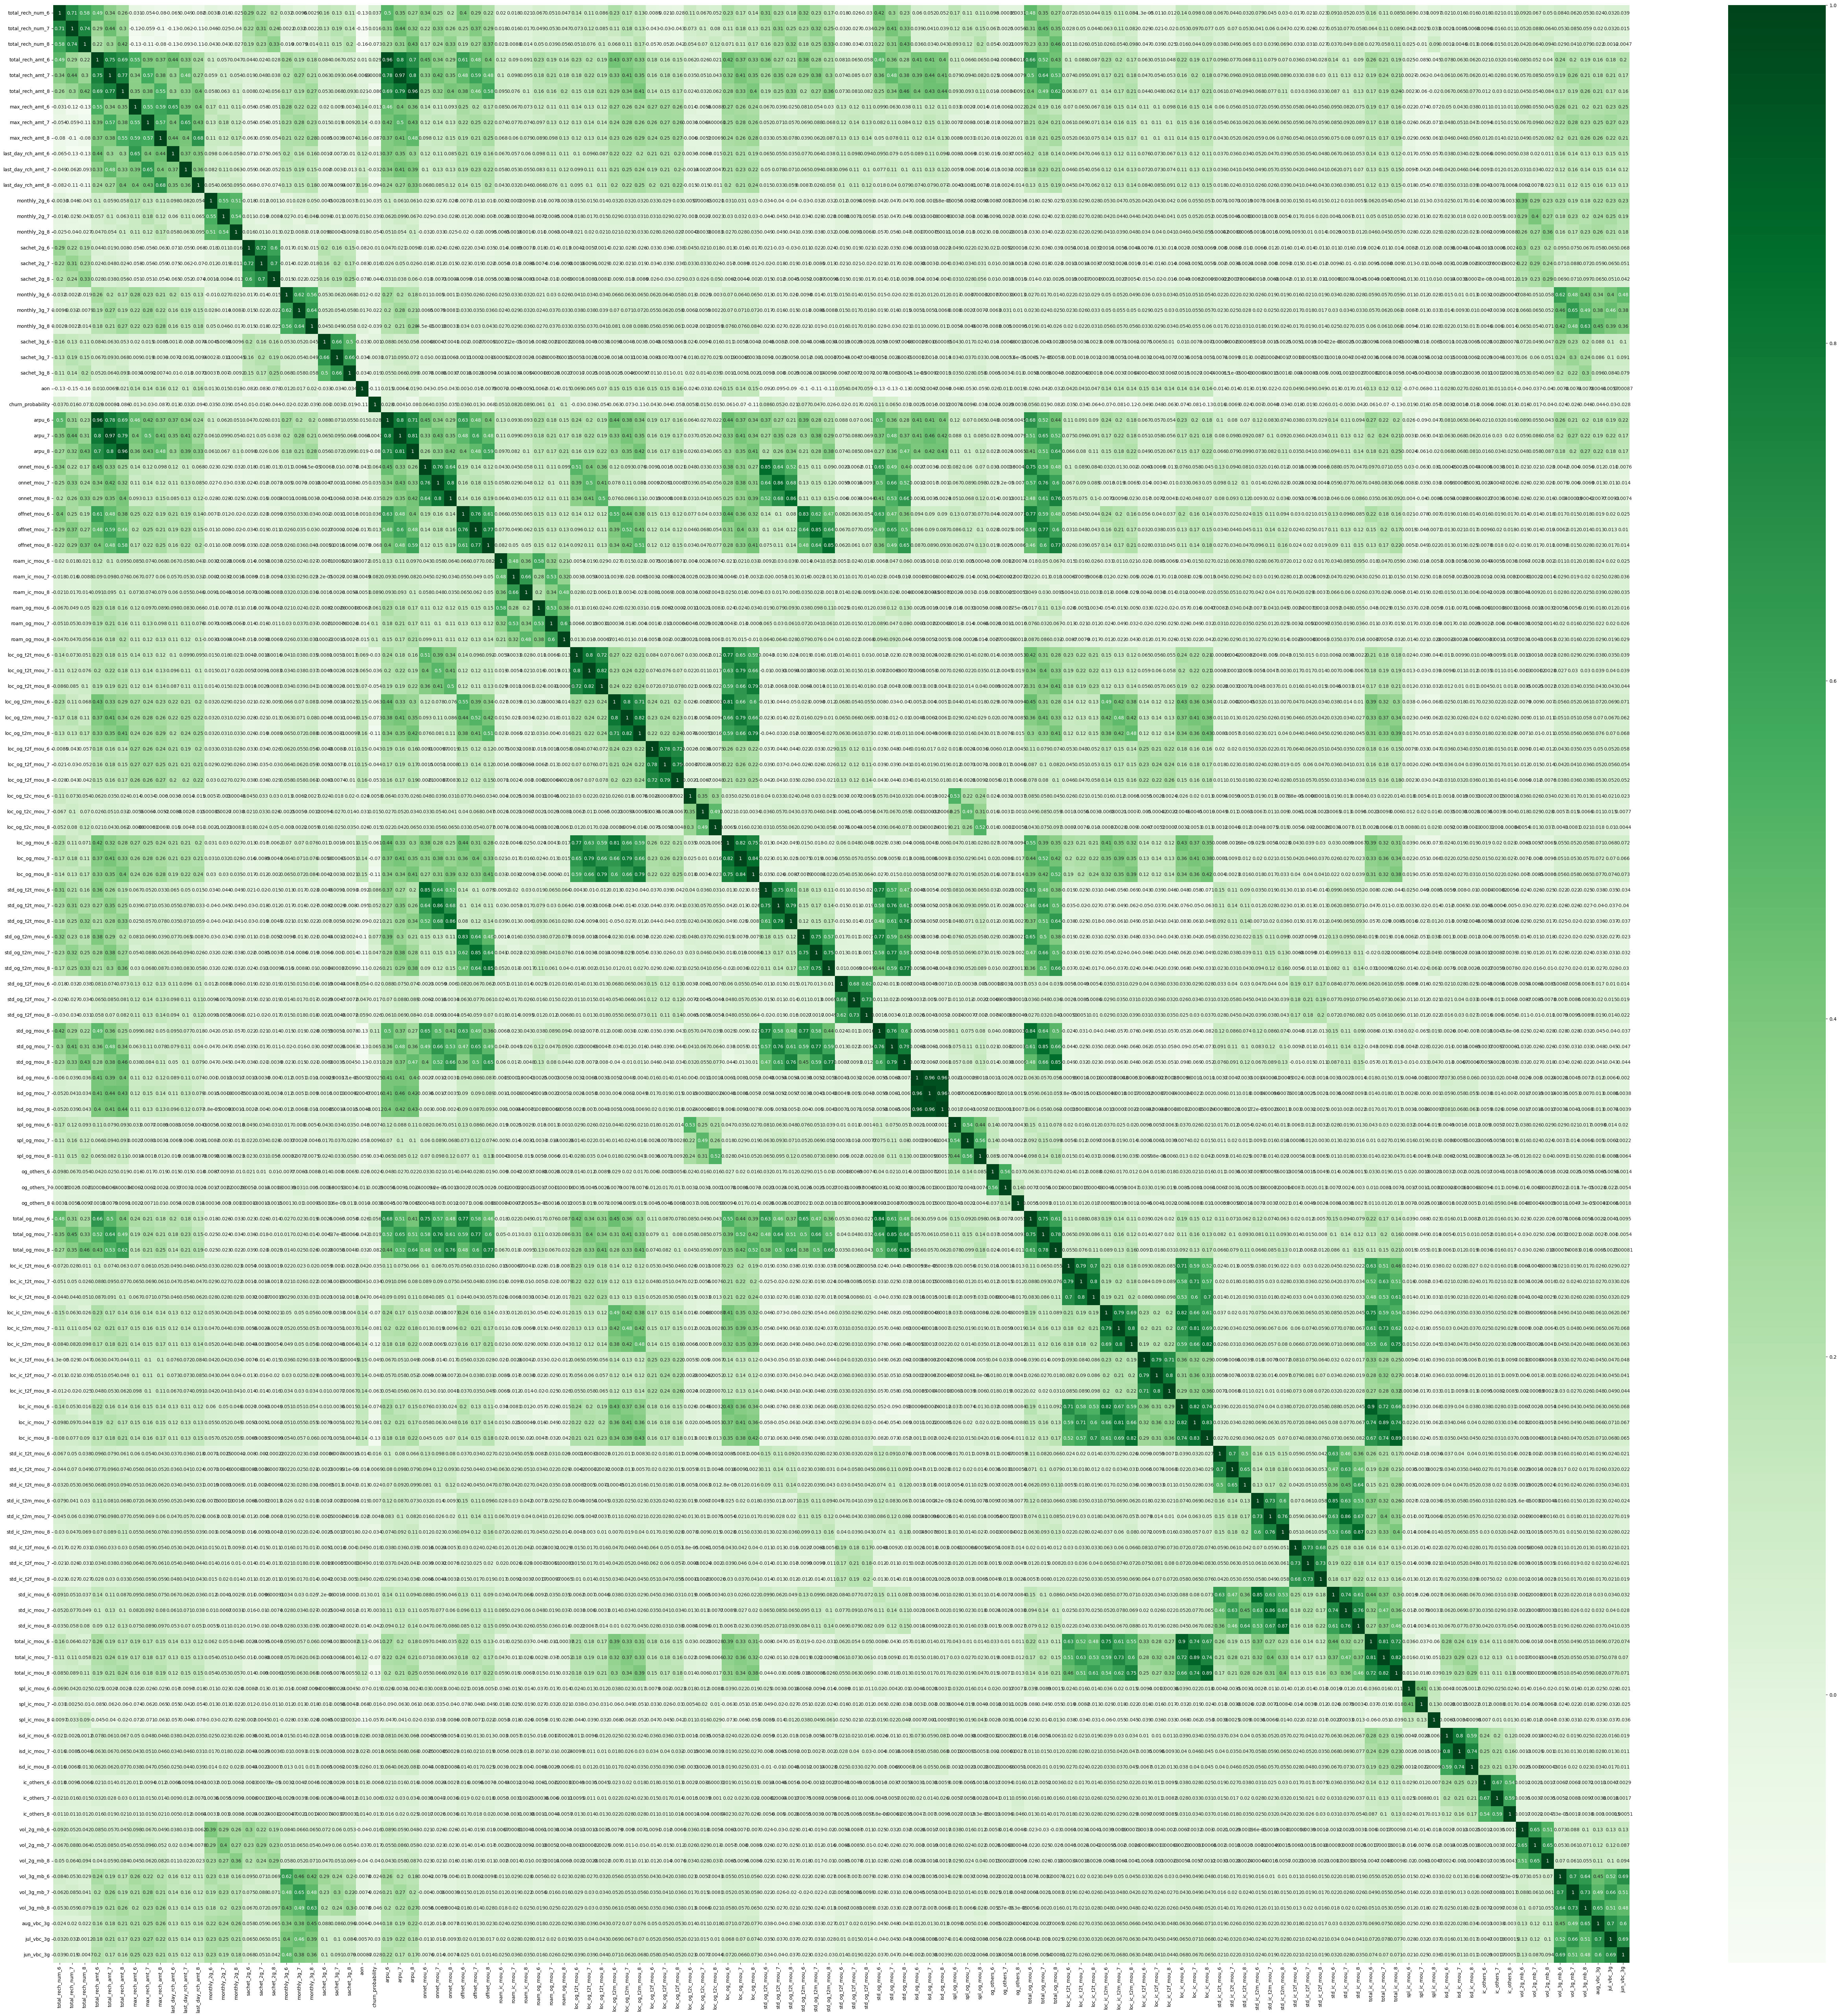

In [10]:
plt.figure(figsize=(75,75))
sns.heatmap(df_train[numeric_cols].corr(),cmap='Greens',annot=True)
plt.show()

In [11]:
df_train_labelled, df_test_labelled = 

SyntaxError: invalid syntax (4271251474.py, line 1)